# CAB420 Assignment 1A Question 1

## Overview



In [70]:
# numpy handles pretty much anything that is a number/vector/matrix/array
import numpy as np
# pandas handles dataframes
import pandas as pd
# matplotlib emulates Matlabs plotting functionality
import matplotlib.pyplot as plt
# seaborn is another good plotting library. In particular, I like it for heatmaps (https://seaborn.pydata.org/generated/seaborn.heatmap.html)
import seaborn as sns;
# stats models is a package that is going to perform the regression analysis
from statsmodels import api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score

# os allows us to manipulate variables on out local machine, such as paths and environment variables
import os
# self explainatory, dates and times
from datetime import datetime, date
# a helper package to help us iterate over objects
import itertools

train = pd.pandas.read_csv('communities_train.csv')
val = pd.pandas.read_csv('communities_val.csv')
test = pd.pandas.read_csv('communities_test.csv')

X_train = train.iloc[:,0:-1]
y_train = train.iloc[:,-1]
X_val = val.iloc[:,0:-1]
y_val = val.iloc[:,-1]
X_test = test.iloc[:,0:-1]
y_test = test.iloc[:,-1]

## Standardisation

In [71]:
def standardise(data):
  """ Standardise/Normalise data to have zero mean and unit variance

  Args:
    data (np.array):
      data we want to standardise (usually covariates)

    Returns:
      Standardised data, mean of data, standard deviation of data
  """
  mu = np.mean(data, axis=0)
  sigma = np.std(data, axis=0)
  scaled = (data - mu) / sigma
  return scaled, mu, sigma

In [72]:
X_train, mu_train_x, sigma_train_x = standardise(X_train)
Y_train, mu_train_y, sigma_train_y = standardise(y_train)
X_val = (X_val - mu_train_x)/sigma_train_x
Y_val = (y_val - mu_train_y)/sigma_train_y
X_test = (X_test - mu_train_x)/sigma_train_x
Y_test = (y_test - mu_train_y)/sigma_train_y

## Linear Regression

#### Visualisation

In [73]:
train.head()  # visualising the head of training just to get an understanding of the data

,population,householdsize,racepctblack,racePctWhite,racePctAsian,racePctHisp,agePct12t21,agePct12t29,agePct16t24,agePct65up,...,PctForeignBorn,PctBornSameState,PctSameHouse85,PctSameCity85,PctSameState85,LandArea,PopDens,PctUsePubTrans,LemasPctOfficDrugUn,ViolentCrimesPerPop
0,0.01,0.33,0.00,0.94,0.21,0.11,0.26,0.37,0.22,0.74,...,0.44,0.73,0.90,0.73,0.85,0.01,0.45,0.47,0.0,0.06
1,0.01,0.09,0.02,0.89,0.23,0.13,0.07,0.71,0.27,0.15,...,0.24,0.37,0.25,0.46,0.34,0.00,1.00,0.06,0.0,0.22
2,0.01,0.53,0.02,0.92,0.21,0.03,0.98,1.00,1.00,0.20,...,0.17,0.32,0.13,0.04,0.18,0.01,0.32,0.01,0.0,0.07
3,0.01,0.36,0.00,0.98,0.02,0.00,0.42,0.45,0.29,0.53,...,0.01,0.81,0.50,0.65,0.76,0.04,0.11,0.00,0.0,0.07
4,0.01,0.68,0.01,0.98,0.04,0.01,0.71,0.60,0.62,0.39,...,0.10,0.71,0.67,0.73,0.55,0.08,0.06,0.07,0.0,0.03


#### correlation graph

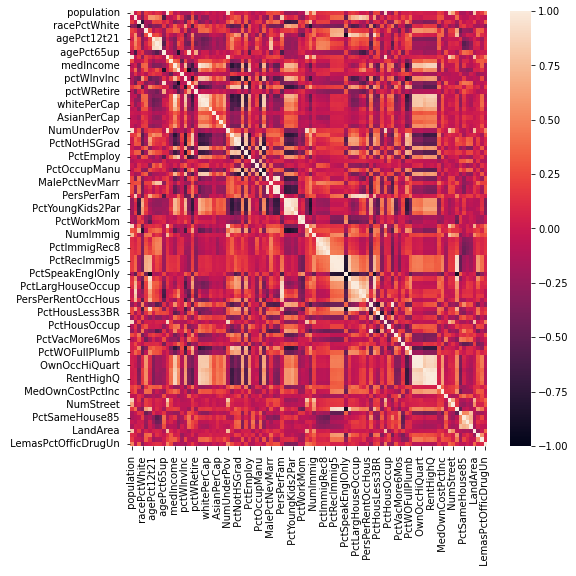

In [74]:
fig, ax = plt.subplots(figsize=(8,8))
ax = sns.heatmap(X_train.corr(), annot=False, vmin=-1.0, vmax=1.0)

#### creating the linear model

Model 1 RMSE = 0.287520268572235
                                  OLS Regression Results                                  
Dep. Variable:      ViolentCrimesPerPop    R-squared (uncentered):                   0.346
Model:                               OLS   Adj. R-squared (uncentered):              0.016
Method:                    Least Squares   F-statistic:                              1.048
Date:                   Tue, 28 Mar 2023   Prob (F-statistic):                       0.386
Time:                           12:32:35   Log-Likelihood:                         -14.711
No. Observations:                    298   AIC:                                      229.4
Df Residuals:                        198   BIC:                                      599.1
Df Model:                            100                                                  
Covariance Type:               nonrobust                                                  
                              coef    std err          t 

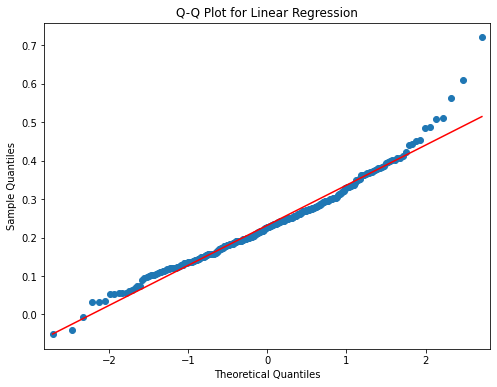

In [75]:
# create and fit linear model
model = sm.OLS(y_train, X_train).fit()

# predicting over the validation data
pred_validation = model.predict(X_val)

print('Model 1 RMSE = {}'.format(
  np.sqrt(mean_squared_error(y_val, model.predict(X_val)))))
print(model.summary())
print(model.params)
fig, ax = plt.subplots(figsize=(8,6))
sm.qqplot(model.resid, ax=ax, line='s')
plt.title('Q-Q Plot for Linear Regression')
plt.show()

#### testing the model TODO: rescale

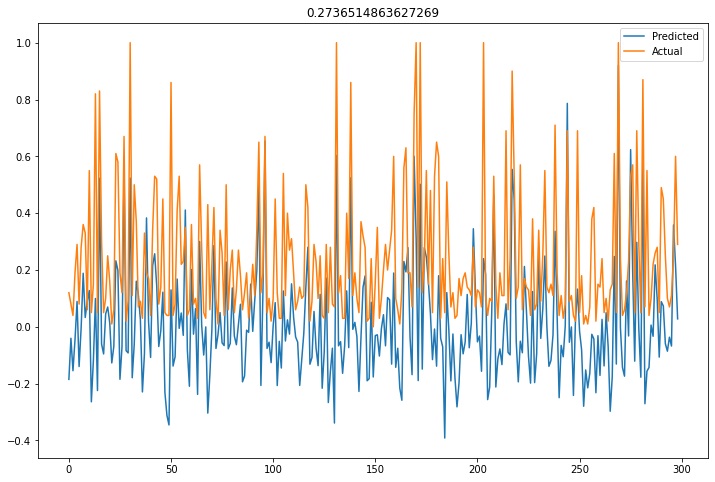

In [76]:
pred = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, pred))
fig = plt.figure(figsize=[12, 8])
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.arange(len(pred)), pred, label='Predicted')
ax.plot(np.arange(len(y_test)), y_test, label='Actual')
ax.set_title(rmse_test)
ax.legend()

### Setup for Regularised regression - taken from Practical as part of CAB420

In [77]:
def rmse(actual, pred):
  return np.sqrt(mean_squared_error(actual, pred))

def r_squared(actual, predicted):
  r2 = r2_score(actual, predicted)
  return r2

def adj_r2(actual, predicted, n, p):
  r2 = r2_score(actual, predicted)
  adjr2 = 1 - (1 - r2) * (n - 1) / (n - p - 1);
  return adjr2

def evaluate_regularisation(x_train, y_train, x_val, y_val, x_test, y_test,
                            response_mu, response_sigma, alpha_list, L1_L2):
  """
  Evaluates the efficacy of regularisation for a linear model.
  
  Identifies which values regression coffections and values of alpha
  (the hyperparam for the strength of regularisation) offers the
  best performance on the validation set.

  Evaluation is required to be performed on the standardised data, to allow
  for ease of comparison (where standardised here refers to normalisation,
  such that the data has a mean of zero and a std. of one.) This will show
  
  Will display the coefficients used in the NORMALISED/STANDARDISED model 
  used to achieve the best results.

  Is able to evaluate both Ridge and Lasso regularisation (and Elasticnet
  really if you want to try it, but in this class we are sticking to Ridge
  and Lasso).

  Args:
    x_train (np.array):
      normalised predictor variable training data
    y_train (np.array):
      normalised response variable training data
    x_val (np.array):
      normalised predictor variable validation data
    y_val (np.array):
      normalised response variable validation data
    x_test (np.array):
      normalised predictor variable test data
    y_test (np.array):
      normalised response variable test data
    response_mu (np.array):
      the mean value of the response variable from the TRAINING data
    response_sigma (np.array):
      the standard deviation  of the response variable from the TRAINING data
    alpha_list (list[np.float]):
      proposed values for alpha (the regularisation hyper param, also called
      lambda in other texts and in the lectures). Each value must be greater
      than zero.
    L1_L2 (np.int):
      Boolean to say whether we want to perform Ridge or Lasso regularisation.
      When zero, will be Ridge, When one, will be Lasso.
      Note: this value can actually be a float between zero and one as well 
      if you want to try Elasticnet regression, but here in this class would
      recommend sticking to just Ridge and Lasso.

  Retuns:
    NA
  """
  # Ridge: L1_L2 = 0
  # Lasso: L1_L2 = 1
  # create the model
  model = sm.OLS(y_train, x_train)
  # initialise the value for best RMSE that is obnoxiously large, as we want this be 
  # overwritten each time RMSE is smaller, since smaller is better and we want to 
  # update our best models each time the RMSE is smaller.
  best_rmse = 10e12
  best_alpha = []
  best_coeffs = []
  
  rmse_val = []
  rmse_train = []
  coeffs = []          # only needed for trace plots

  for alpha in alpha_list:
    model_cross_fit = model.fit_regularized(alpha=alpha, L1_wt=L1_L2)
    train_pred = model_cross_fit.predict(x_train)
    val_pred = model_cross_fit.predict(x_val)
    # want to append the rmse value to a list, as will plot all values later on
    rmse_train.append(np.sqrt(mean_squared_error(y_train, train_pred)))
    rmse_val.append(np.sqrt(mean_squared_error(y_val, val_pred)))
    coeffs.append(model_cross_fit.params)
    # if this is the model with the lowest RMSE, lets save it
    # the [-1] index says get the last value from the list (which is the most recent RMSE)
    if rmse_val[-1] < best_rmse:
      best_rmse = rmse_val[-1]
      best_alpha = alpha
      best_coeffs = model_cross_fit.params
      
  print('Best values on Validation Data set')
  # extract the gradient and the bias from the coefficients
  # The reshape will make sure the slope is a column vector
  slope = np.array(best_coeffs[0:]).reshape(-1, 1)
  # the intercept coefficient is the last index variable, which was included with the
  # sm.add_constant() method
  # use the @ operator to perform vector/matrix multiplication
  pred_val_rescaled = (x_val @ slope) * response_sigma + response_mu
  pred_test_rescaled = (x_test @ slope) * response_sigma + response_mu
  pred_train_rescaled = (x_train @ slope) * response_sigma + response_mu
  best_r2 = r_squared(y_train * response_sigma + response_mu, pred_train_rescaled)
  best_adj_r2 = adj_r2(y_train * response_sigma + response_mu, pred_train_rescaled,
                           x_train.shape[0], x_train.shape[1]) 
  best_val_rmse = np.sqrt(mean_squared_error(y_val* response_sigma + response_mu, pred_val_rescaled))
  best_test_rmse = np.sqrt(mean_squared_error(y_test* response_sigma + response_mu, pred_test_rescaled))
  print('Best Alpha = {}'.format(best_alpha))
  print('Best R Squared = {}'.format(best_r2))
  print('Best Adjusted = {}'.format(best_adj_r2))
  print('Best RMSE (val) = {}'.format(best_val_rmse))
  print('Best RMSE (test) = {}'.format(best_test_rmse))
  print('Best coefficients on the normalised model')
  print('Best slope = {}'.format(slope))
  
  # now plotting some data
  fig, axs = plt.subplots(5, figsize=(15, 25))
  
  # plot the first values of alpha vs RMSE for train and validation data    
  axs[0].plot(np.array(alpha_list), rmse_train)
  axs[0].plot(np.array(alpha_list), rmse_val)
  axs[0].legend(['Training', 'Validation'])
  axs[0].set_title('RMSE vs Lambda')
  axs[0].set_xlabel('Lambda')
  axs[0].set_ylabel('RMSE')    
  
  # plot prediction and true values for test set
  axs[1].plot((y_test*response_sigma + response_mu))
  axs[1].plot((x_test @ slope) * response_sigma + response_mu)
  axs[1].legend(['Actual', 'Predicted'])
  axs[1].set_title('Test Set Performance')
  
  # plotting the Q-Q plot
  train_pred = (x_train @ slope).reshape(y_train.shape)
  resid = y_train - train_pred
  sm.qqplot(resid, ax=axs[2], line='s')
  axs[2].set_title('Q-Q Plot for Linear Regression')

  # plot the residuals as well
  axs[3].scatter(train_pred, resid)
  axs[3].set_title('Residuals for training set')
  axs[3].set_xlabel('Predicted')
  axs[3].set_ylabel('Residuals')

  # trace plot of coefficients
  axs[4].plot(np.array(alpha_list), coeffs)
  axs[4].set_title('Trace PLot of Coefficients')
  axs[4].set_xlabel('Lambda')
  axs[4].set_ylabel('Coefficient Value')    

In [78]:
# converting data frames to numpy
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_val = X_val.to_numpy()
y_val = y_val.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

## Ridge Regression

Best values on Validation Data set
Best Alpha = 0.01001001001001001
Best R Squared = -0.4527282675505253
Best Adjusted = -1.1901537840736345
Best RMSE (val) = 0.06014146329982468
Best RMSE (test) = 0.05718890592376682
Best coefficients on the normalised model
Best slope = [[ 0.00731932]
 [-0.04064923]
 [ 0.00838894]
 [-0.01775003]
 [-0.00791732]
 [-0.07668269]
 [-0.03327977]
 [ 0.03047409]
 [ 0.02797983]
 [ 0.01697743]
 [-0.00980585]
 [ 0.01874071]
 [ 0.02809979]
 [-0.02385663]
 [ 0.0072846 ]
 [-0.03755365]
 [ 0.02802567]
 [ 0.0133944 ]
 [-0.02164104]
 [ 0.01326679]
 [ 0.01250182]
 [-0.01768553]
 [ 0.00298652]
 [-0.00847393]
 [ 0.02192056]
 [-0.00138179]
 [ 0.0090555 ]
 [-0.00979805]
 [-0.05299212]
 [-0.02587039]
 [ 0.02350291]
 [ 0.03024723]
 [-0.02931515]
 [ 0.04051788]
 [-0.02001861]
 [-0.00181803]
 [ 0.00793657]
 [-0.00145722]
 [-0.00376079]
 [ 0.00501146]
 [-0.01389785]
 [ 0.00207907]
 [ 0.0338348 ]
 [-0.02928984]
 [-0.03177857]
 [-0.01180944]
 [-0.00380091]
 [ 0.02434735]
 [-0.03

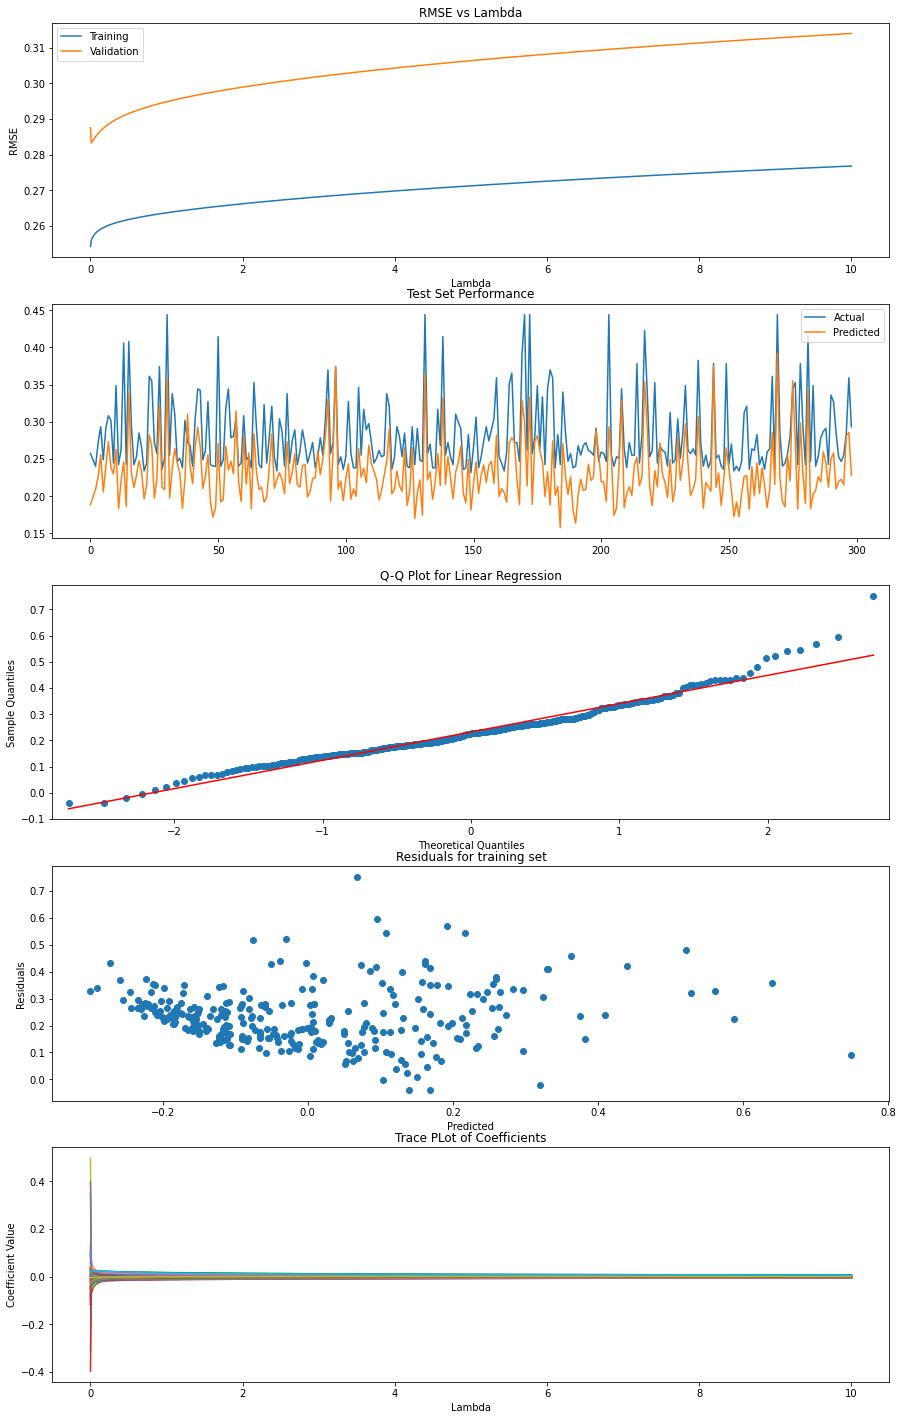

In [79]:
alpha_list = np.linspace(0, 10.0, 1000)
evaluate_regularisation(X_train, y_train, X_val, y_val, X_test, y_test,
                        mu_train_y, sigma_train_y, alpha_list, 0)

## Lasso Regression

Best values on Validation Data set
Best Alpha = 0.0002002002002002002
Best R Squared = -0.4779450112063004
Best Adjusted = -1.2281709052196508
Best RMSE (val) = 0.06021270217060914
Best RMSE (test) = 0.056541479628720595
Best coefficients on the normalised model
Best slope = [[ 0.00794371]
 [ 0.        ]
 [ 0.00881319]
 [-0.01953203]
 [-0.01028957]
 [-0.05708059]
 [ 0.        ]
 [ 0.01401676]
 [ 0.        ]
 [ 0.03028562]
 [ 0.        ]
 [ 0.01570675]
 [ 0.00198149]
 [-0.0086614 ]
 [ 0.        ]
 [-0.02556368]
 [ 0.        ]
 [ 0.        ]
 [-0.02446572]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [-0.00786117]
 [ 0.02458478]
 [ 0.        ]
 [ 0.01036628]
 [ 0.01771878]
 [-0.05407116]
 [ 0.        ]
 [ 0.02041307]
 [ 0.02163717]
 [-0.01933243]
 [ 0.03156121]
 [-0.022576  ]
 [-0.00277404]
 [ 0.        ]
 [-0.02933913]
 [-0.00875404]
 [ 0.        ]
 [-0.00242668]
 [ 0.        ]
 [ 0.08032644]
 [-0.08389485]
 [ 0.        ]
 [-0.01405042]
 [ 0.        ]
 [ 0.        ]
 [-0

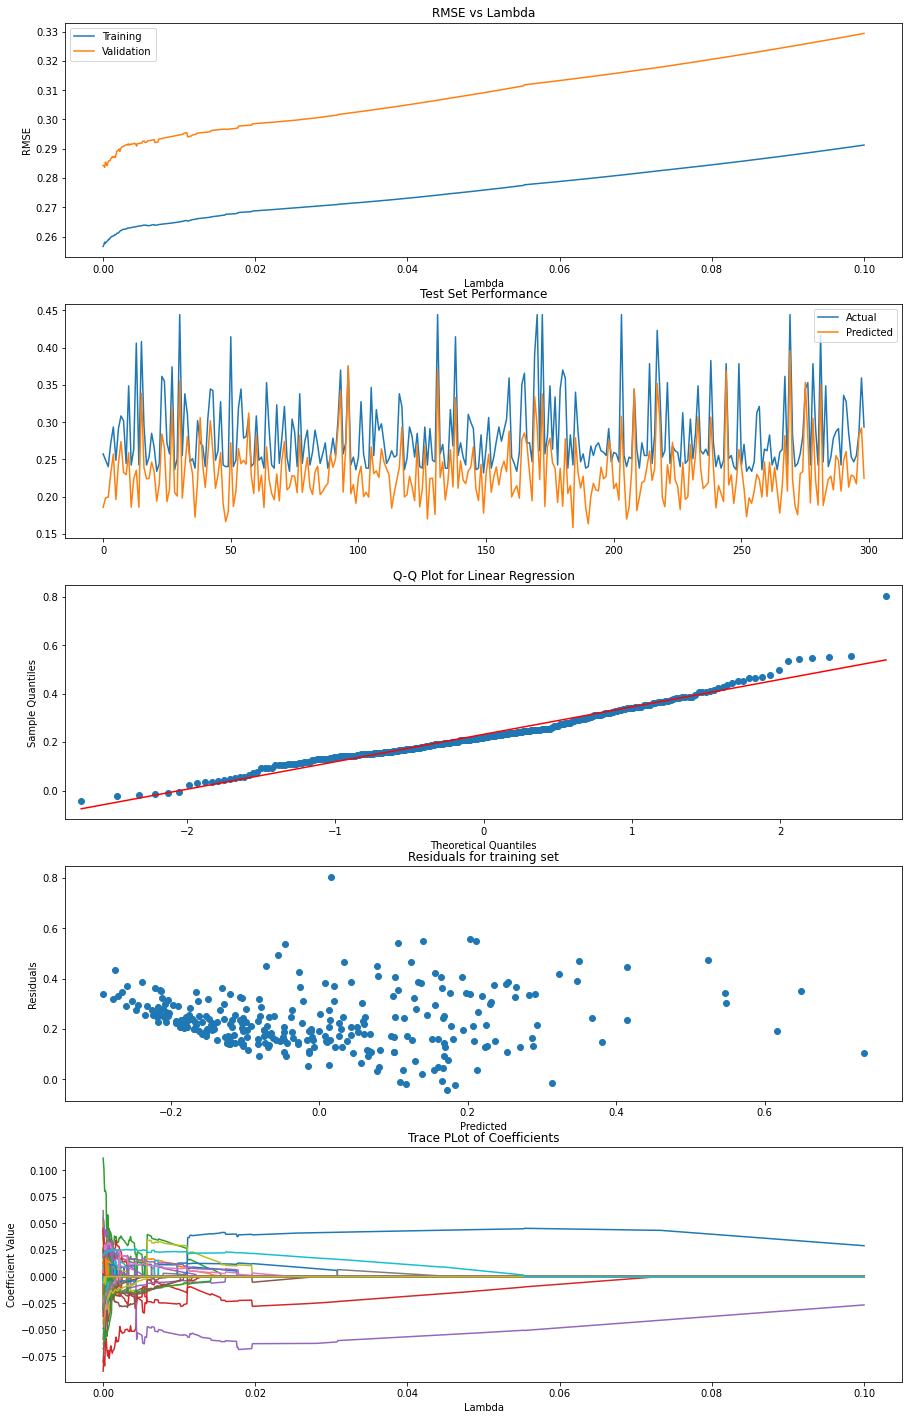

In [81]:
alpha_list = np.linspace(0, 0.1, 1000)
evaluate_regularisation(X_train, y_train, X_val, y_val, X_test, y_test,
                        mu_train_y, sigma_train_y, alpha_list, 1)